# **Этап 1: Подготовка данных**

In [ ]:
import requests

URL_LAUREATES = "https://api.nobelprize.org/2.1/laureates?limit=1200"

laureates_response = requests.get(URL_LAUREATES)
laureates = laureates_response.json()

In [2]:
from laureates_configs import org_processor, person_processor
from prizes_configs import prize_processor

person_proc = person_processor()
org_proc = org_processor()
prize_proc = prize_processor()


def get_laureate_data(laureate: dict):
    """
    Определите тип лауреата and соотв образом обработайте данных.

    Args:
        laureate: Dictionary with laureate data

    Returns:
        Processed laureate data with added 'type_' field ('person' or 'org')

    Determines type by:
    - 'knownName' key → person (uses process_persons)
    - 'orgName' key → org (uses process_orgs)
    """
    if laureate.get("knownName") is not None:
        processed_data = person_proc(laureate)
        processed_data["type_"] = "person"
    elif laureate.get("orgName") is not None:
        processed_data = org_proc(laureate)
        processed_data["type_"] = "org"
    else:
        raise Exception("Unknown laureate type")

    return {**processed_data}


laureates_data = []

for laureate in laureates["laureates"]:
    laureates_data.append(get_laureate_data(laureate))

In [3]:
get_laureate_data(laureates["laureates"][0])

{'id': 745,
 'name': 'A. Michael Spence',
 'gender': 'male',
 'birth_year': 1943,
 'country_birth': 'USA',
 'country_now': 'USA',
 'prizes_relevant': [{'prize_amount': 10000000,
   'prize_amount_adjusted': 15547541,
   'award_year': 2001,
   'category_en': 'Economic Sciences',
   'prize_status': 'received'}],
 'type_': 'person'}

# **Этап 2: EDA лауреатов**

## Предварительные вопросы

1. Сколько всего записей?

In [ ]:
print(f"Всего записей: {len(laureates_data)}")

Всего записей: 1018


2. Все ли значения полей заполнены?

In [50]:
for laureate in laureates_data:
    breakpoint = False
    for key, value in laureate.items():
        if value is None:
            print(True)
            breakpoint = True
            break
    if breakpoint:
        break
else:
    print(False)

True


3. Если нет, сколько пропусков в каждом из полей? А какая доля пропусков?

In [5]:
from dataset_helpers import get_none_counts, get_attribute_counts


none_counts = get_none_counts(laureates_data)
normalized_none_counts = get_none_counts(laureates_data, normalized=True)

display(none_counts, normalized_none_counts)

{'country_birth': 4, 'country_now': 8, 'country_founded': 4, 'founded_year': 1}

{'country_birth': 0.004,
 'country_now': 0.0079,
 'country_founded': 0.1429,
 'founded_year': 0.0357}

4. Каковы максимальные и минимальные значения поля id и каким годам награждения они соответствуют?

In [6]:
from aggregations import get_max_by_attribute, get_min_by_attribute
from dataset_helpers import get_awarded_laureates, get_data_by_id


awarded_laureates = get_awarded_laureates(laureates_data)
min_id, max_id = (
    get_min_by_attribute(awarded_laureates, "id"),
    get_max_by_attribute(awarded_laureates, "id"),
)

min_id_years, max_id_years = (
    [id_prize_data["award_year"] for id_prize_data in get_data_by_id(awarded_laureates, min_id)["prizes_relevant"]],
    [
        id_prize_data["award_year"] for id_prize_data in get_data_by_id(awarded_laureates, max_id)["prizes_relevant"]
    ],  # так как некоторые лауреаты получали больше одной награды соберем списки
)

print(min_id, min_id_years)
print(max_id, max_id_years)

1 [1901]
1060 [2025]


Есть ли записи с повторяющимися id?

In [51]:
get_attribute_counts(laureates_data)["id"], len({laureate["id"] for laureate in laureates_data})

(1018, 1018)

 Есть ли пары айди, которые в отсортированном массиве айдишников различаются более, чем на один?

In [8]:
def missing_ids(laureates_data):
    ids = [laureate["id"] for laureate in laureates_data]
    return [i for i in range(min(ids), max(ids) + 1) if i not in ids]


missed_ids = missing_ids(laureates_data)
print(missed_ids)
print(len(missed_ids))

[7, 94, 170, 171, 256, 469, 504, 521, 522, 542, 570, 591, 595, 598, 599, 611, 612, 616, 632, 636, 646, 656, 784, 785, 788, 859, 860, 897, 898, 899, 900, 901, 902, 950, 951, 952, 953, 954, 955, 956, 957, 1010]
42


## **Анализ данных о лауреатах**

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

### **2.1. Топ-статистика по странам**
- Топ стран по общему количеству лауреатов
- Развитие числа лауреатов разных стран в течение времени

Рассмотрим топ 5 стран по количеству лауреатов

In [ ]:
from dataset_helpers import group_by
from aggregations import get_top_k_values_by_attribute

countries_grouped = group_by(laureates_data, ["country_birth"], len)  # сгруппируем по стране лауреата и вернем количество лауреатов в каждой стране
countries_data = [
    {"count_per_country": (count, country)} for country, count in countries_grouped.items()
]  # переведем в нужный для ранжирования формат
top_5_countries_data = get_top_k_values_by_attribute(countries_data, "count_per_country", 5)  # возьмем топ 5 стран

top_5_countries_data

[(295, 'USA'),
 (94, 'United Kingdom'),
 (80, 'Germany'),
 (60, 'France'),
 (30, 'Sweden')]

Визуализируем полученные результаты

In [61]:
# поделим данные на два массива для визуализации
top_5_countries_counts = [count for count, _ in top_5_countries_data]
top_5_countries = [country for _, country in top_5_countries_data]

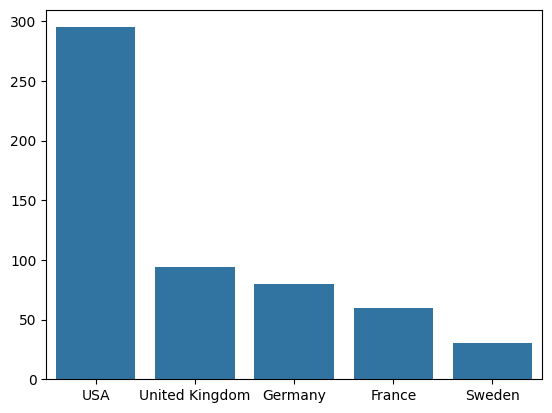

In [12]:
sns.barplot(x=top_5_countries, y=top_5_countries_counts)
plt.show()

 **США занимают лидирующую позицию** с большим отрывом

Посмотрим на изменение числа номинантов по десятилетиям

In [ ]:
laureates_with_decade = laureates_data.copy()

for laureate in laureates_with_decade:
    if laureate.get("country_birth") and (laureate["country_birth"] == "Russian Empire"):  # соединим записи для России и Российской Империи
        laureate["country_birth"] = "Russia"
    if laureate.get("prizes_relevant"):  # вручную добавим аттрибут декада вручения премии
        for prize in laureate["prizes_relevant"]:
            if prize.get("award_year"):
                year = prize["award_year"]
                decade = (year // 10) * 10
                prize["award_decade"] = decade

laureates_by_decade_and_country = group_by(laureates_with_decade, [["prizes_relevant", "award_decade"], ["country_birth"]], len)

In [ ]:
def make_plot_data_for_decade_groupby(laureates_by_decade_and_attribute):
    """
    функция представления данных из groupby в удобном для построения графика формате
    по каждой стране будет созданно два массива
    на i-ой позициях будет декада и кол-во номинантов в этой декаде
    """
    plot_data = {}

    for (decade, attribute), count in laureates_by_decade_and_attribute.items():
        if not decade:
            continue

        if attribute not in plot_data:
            plot_data[attribute] = {"decades": [], "counts": []}

        plot_data[attribute]["decades"].append(decade)
        plot_data[attribute]["counts"].append(count)

    for attribute in plot_data:
        zipped_data = sorted(zip(plot_data[attribute]["decades"], plot_data[attribute]["counts"]))

        if zipped_data:
            sorted_decades, sorted_counts = zip(*zipped_data)
            plot_data[attribute]["decades"] = list(sorted_decades)
            plot_data[attribute]["counts"] = list(sorted_counts)

    return plot_data

In [15]:
plot_data_countries = make_plot_data_for_decade_groupby(laureates_by_decade_and_country)

In [ ]:
country_totals = {}  # словарь для подсчета итогового кол-ва лауреатов в каждой стране
for (decade, country), count in laureates_by_decade_and_country.items():
    if country:
        country_totals[country] = country_totals.get(country, 0) + count


MIN_LAUREATES_THRESHOLD = 17  # порог, чтобы избежать загромождения графика

countries_to_plot = [country for country, total in country_totals.items() if total >= MIN_LAUREATES_THRESHOLD]

In [ ]:
def plot_accumulated_counts(plot_data, domain=None):
    """
    функция для построения графика накопительных данных
    """
    if not domain:
        domain = plot_data.keys()
    for attribute, data in plot_data.items():
        if domain and attribute in domain:
            cumulative_counts = []
            running_total = 0
            for count in data["counts"]:
                running_total += count
                cumulative_counts.append(running_total)

            plt.plot(
                data["decades"],
                cumulative_counts,
                marker=".",
                label=attribute,
            )

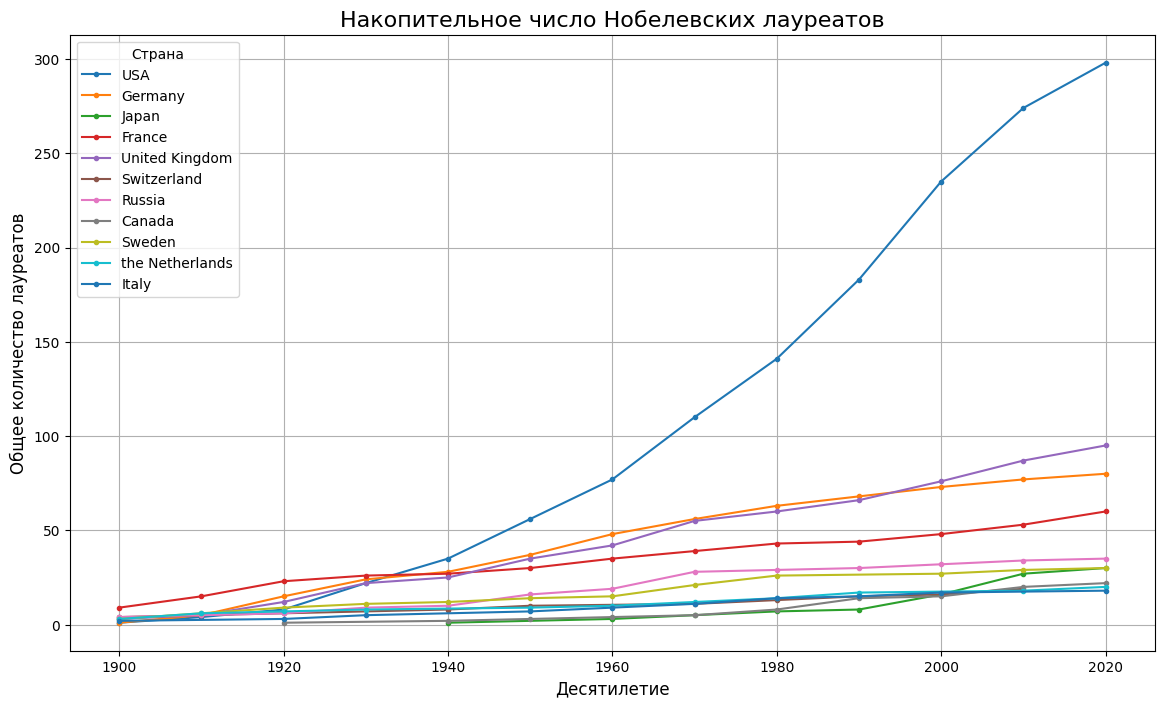

In [45]:
plt.figure(figsize=(14, 8))
plt.title(
    "Накопительное число Нобелевских лауреатов",
    fontsize=16,
)

plot_accumulated_counts(plot_data_countries, countries_to_plot)

plt.xlabel("Десятилетие", fontsize=12)
plt.ylabel("Общее количество лауреатов", fontsize=12)
plt.legend(title="Страна", fontsize=10)
plt.grid(True)
plt.show()

Как видно из графика, США являются лидером по общему числу Нобелевских лауреатов за всю историю. График по декадам показывает, что их доминирование началось в середине XX века

Также рассмотрим в каких категориях наибольшее число лауреатов

In [ ]:
categories_grouped = group_by(laureates_data, ["prizes_relevant", "category_en"], len)
categories_grouped
categories_data = [{"count_per_category": (count, category)} for category, count in categories_grouped.items()]
top_categories_data = get_top_k_values_by_attribute(categories_data, "count_per_category", 6)  # категорий всего 6, возьмем все
top_categories_data

[(232, 'Physiology or Medicine'),
 (230, 'Physics'),
 (200, 'Chemistry'),
 (143, 'Peace'),
 (122, 'Literature'),
 (99, 'Economic Sciences')]

Визуализируем полученные результаты

In [19]:
top_categories_counts = [count for count, _ in top_categories_data]
top_categories = [category for _, category in top_categories_data]

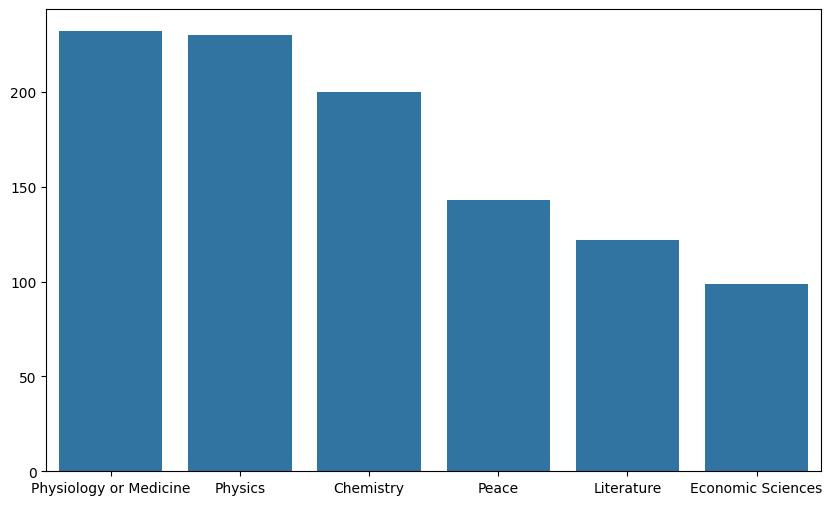

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_categories, y=top_categories_counts)
plt.show()

Анализ по категориям показывает, что **естественные науки являются более богатыми** на нобелевских лауреатов. 

### **2.2. Топ-статистика по категориям**
- Топ категорий по общему количеству лауреатов
- Развитие числа лауреатов различных категорий в течение времени

Также посмотрим на то, как менялось число выданных наград в разных категориях по декадам

In [ ]:
laureates_by_decade_and_category = group_by(laureates_with_decade, [["prizes_relevant", "award_decade"], ["prizes_relevant", "category_en"]], len)

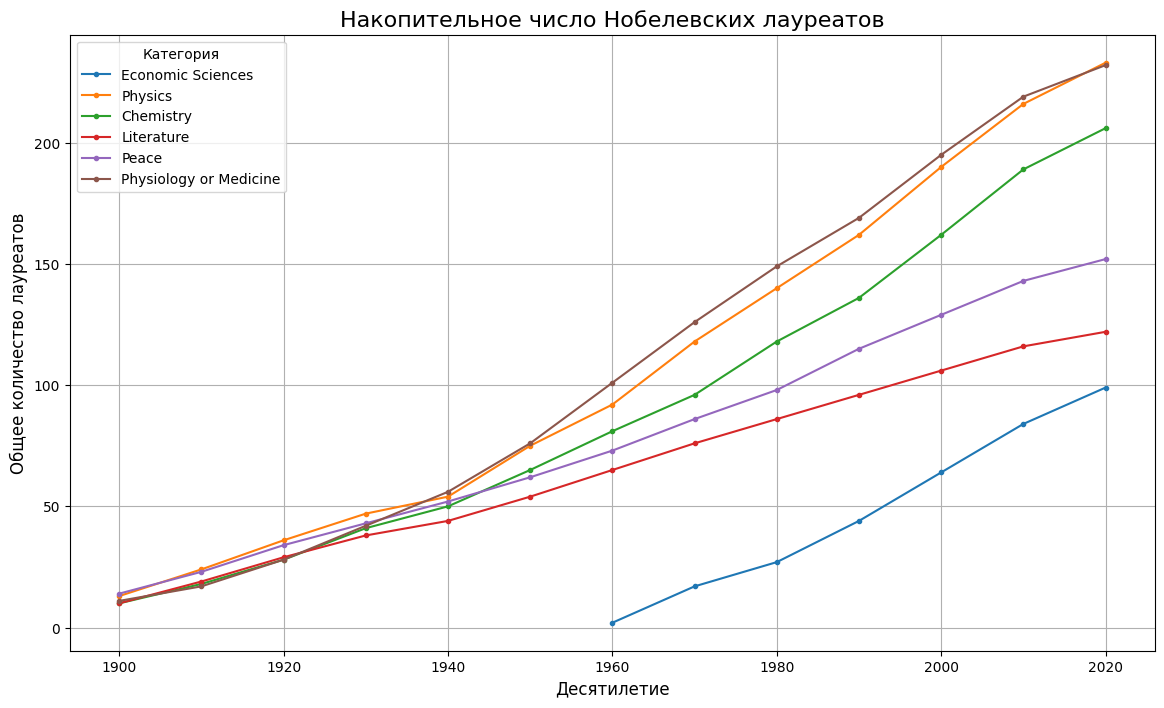

In [63]:
plot_data_category = make_plot_data_for_decade_groupby(laureates_by_decade_and_category)

plt.figure(figsize=(14, 8))
plt.title(
    "Накопительное число Нобелевских лауреатов",
    fontsize=16,
)

plot_accumulated_counts(plot_data_category)

plt.xlabel("Десятилетие", fontsize=12)
plt.ylabel("Общее количество лауреатов", fontsize=12)
plt.legend(title="Категория", fontsize=10)
plt.grid(True)
plt.show()

Накопительный график показывает стабильный рост числа награжденных во всех дисциплинах на протяжении времени. Можно заметить, что Экономические науки, премии по которым стали выдавать только с 1960 года, стремительно догоняют остальные категории

### **2.3. Многократные лауреаты**
- Кто получил премию больше 2 раз?
- Совпадает ли категория второго приза с первой?
- Сколько в среднем времени прошло между получением первой и второй премии?

In [ ]:
from attribute_manager import add_attribute
from dataset_helpers import filter_by_attribute

laureates_data_with_prize_count = laureates_data.copy()
# для каждого лауреата добавим аттрибут - количество наград
prize_count = {laureate["id"]: len(laureate["prizes_relevant"]) for laureate in laureates_data_with_prize_count if laureate.get("prizes_relevant")}

laureates_data_with_prize_count = add_attribute(laureates_data_with_prize_count, "prize_count", prize_count)

multiple_laureates_data = filter_by_attribute(laureates_data_with_prize_count, ["prize_count"], lambda x: x > 1)
print(f"Всего многократных лауреатов: {len(multiple_laureates_data)}")

Всего многократных лауреатов: 7


In [64]:
print("Список многократных лауреатов и категории их наград: ", end="\n\n")
for laureate in multiple_laureates_data:
    print(laureate["name"])
    categories = {prize["category_en"] for prize in laureate["prizes_relevant"]}
    print(*categories, sep=", ", end="\n\n")

Список многократных лауреатов и категории их наград: 

Frederick Sanger
Chemistry

International Committee of the Red Cross
Peace

John Bardeen
Physics

K. Barry Sharpless
Chemistry

Linus Pauling
Chemistry, Peace

Marie Curie
Chemistry, Physics

Office of the United Nations High Commissioner for Refugees
Peace



Можно заметить, что получение Нобелевской премии более одного раза крайне редкое достижение. А случаев, когда лауреаты получали две премии в разных категориях всего 2.

In [27]:
def get_time_between_prizes(laureate):
    prizes = laureate["prizes_relevant"]
    times = []
    for i in range(1, len(prizes)):
        times.append(prizes[i]["award_year"] - prizes[i - 1]["award_year"])
    return times


times_between_prizes = {laureate["id"]: get_time_between_prizes(laureate) for laureate in multiple_laureates_data}

times_between_prizes

{222: [22], 482: [27, 19], 66: [16], 743: [21], 217: [8], 6: [8], 515: [27]}

In [47]:
mean_time_between_prizes = sum(x[0] for x in times_between_prizes.values()) / len(multiple_laureates_data)
print(f"Среднее время между наградами: {round(mean_time_between_prizes, 4)} лет")

Среднее время между наградами: 18.4286 лет


Среднее время между получением первой и второй премии составляет около **18,5 лет**

### **2.4 Отказы от премий**
- В каких категориях чаще отказывались от премий?
- Есть ли отказы среди организаций?

In [29]:
declined_data = filter_by_attribute(laureates_data, ["prizes_relevant", "prize_status"], lambda x: x == "declined")
declined_data

[{'id': 637,
  'name': 'Jean-Paul Sartre',
  'gender': 'male',
  'birth_year': 1905,
  'country_birth': 'France',
  'country_now': 'France',
  'prizes_relevant': [{'prize_amount': 273000,
    'prize_amount_adjusted': 3576149,
    'award_year': 1964,
    'category_en': 'Literature',
    'prize_status': 'declined',
    'award_decade': 1960}],
  'type_': 'person',
  'prize_count': 1},
 {'id': 531,
  'name': 'Le Duc Tho ',
  'gender': 'male',
  'birth_year': 1911,
  'country_birth': 'Vietnam',
  'country_now': 'Vietnam',
  'prizes_relevant': [{'prize_amount': 510000,
    'prize_amount_adjusted': 4213275,
    'award_year': 1973,
    'category_en': 'Peace',
    'prize_status': 'declined',
    'award_decade': 1970}],
  'type_': 'person',
  'prize_count': 1}]

In [52]:
for laureate in declined_data:
    if laureate["type_"] == "org":
        print(laureate["name"])
else:
    print("Нет организаций, у которых были отказы")

Нет организаций, у которых были отказы


In [60]:
print("Лауреаты, отказавшиеся от премии: ", end="\n\n")
for laureate in declined_data:
    print(laureate["name"])

Лауреаты, отказавшиеся от премии: 

Jean-Paul Sartre
Le Duc Tho 


In [30]:
declined_categories = group_by(declined_data, ["prizes_relevant", "category_en"], len)
print("Категории, в которых были отказы: ", end="\n\n")
print(*declined_categories, sep=", ")

Категории, в которых были отказы: 

Literature, Peace


За всю историю зафиксировано всего **два случая отказа** от премии